<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/draft_sequences/RosenbachP2C1_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.2: Optimization in Two Dimensions: Estimating Gradients**

### Objective: Solve simple 2 dimensional optimization problems using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Extend the perturbation based methods used in the previous sequence to the 2-dimesional case.

* Introduce a simple artificial nerual network model of behaviour for binary discrimination.

* Use the perturb -> measure -> step learning rule to optimize a stochastic strike-no-strike policy for a lurk and strike predator.

* Show how perturb -> measure -> update can be used to estimate gradients in 2 dimensions and how important gradients are when the updates to multiple parameters need to act in a coordinated fashion.

* Using the intuitions gained from going from 1-d to 2-d reflect on how well (or not) our current methods will scale to higher dimensional problems.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.2.1: Optimizing a Polynomial of Two Variables Analytically

Last sequence we reviewed the general optimization problem as anything of the form: "Find some set of parameters or values, say $x$, such that some other scalar valued quantity which depends in some way on those values, i.e. a function of $x$, call it $f(x)$, is as large (or small) as possible, subject to some constraints on the possible values of $x$." In other words, we're looking for the best setting on a dial (the value of $x$) that maximizes or minimizes our outcome (the value of $f(x)$), within certain limits (constraints on $x$).

Now we want to think about how we should do this when we have more than one dial to work with. Here's an example. Find a pair of values of $(x,y)$ on in the region $[-2, 2] \times [-2, 2]$ such that $f(x,y) = (1-x)^2 + 20\left(y - x^2\right)^2$ is as small as possible. This can be written more tersely with symbols as:

$$\underset{x,y\in[-2,2]}{\arg \max}\ (1-x)^2 + 20\left(y - x^2\right)^2$$

If you have taken (and remember!) a multivariate calculus course you might recall how this sort of problem can be solved using calculus and algebra. First we take the partial derivatives,

$$
\begin{align}
\frac{\partial f}{\partial x} &= -2 (1-x) - 80 x (y-x^2) \\
\frac{\partial f}{\partial y} &= 40 (y-x^2)
\end{align}
$$

then we set that equal to zero and use our algebra skills to find the pairs of $(x,y)$ values where the derivative is zero. There is precisely one such pair at $(x,y) = (1,1)$.

We also need to check the concavity (whether the curve bends upwards or downwards) to see if this zero-derivative point is a maximum or a minimum (we are looking for a minimum in this case). In the same way that the first derivatives give the slope of $f(x,y)$ in the direction of the two parameters, i.e. the slope of the tangent plane, the second derivative gives the curvature.

$$
\begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \\
\end{bmatrix} = \begin{bmatrix}
240x^2 - 80y + 2 & -80x \\
-80x & 40 \\
\end{bmatrix}
$$

In one dimension the second derivative is just a single number, and the sign of that number tells us whether the curve opens up or down. In two dimensions though the curvature is not just a single number, nor is it even just two numbers (one for $x$ one for $y$) but rather a whole grid of numbers that captures not just the curvature along the $x$ or $y$ dimension, but also capturing the interaction between $x$ and $y$ on the function. This grid of second derivatives of a function is called the Hessian, and is often denoted as
$H(f)$. Whether or not a critical point (where all the first partial derivatives are equal to zero) is a maximum, a minimum or neither, is determined by an aptly named scalar quantitity called the determinant. This quantity can be computed from the Hessian of our function $H(f)$ as:

$$
\begin{align}
\det(H(f)) &= \left( \frac{\partial^2 f}{\partial x^2} \right)\left( \frac{\partial^2 f}{\partial y^2} \right) - \left( \frac{\partial^2 f}{\partial x \partial y} \right)^2 \\
&= (240x^2 - 80y + 2) \cdot 40 - (-80x)^2
\end{align}
$$

In particular the sign of the determenant, evaluated at a critical point, determines the nature of the critical point:

- If $\Delta > 0$ the point is either a local minimum or maximum.
- If $\Delta < 0$, the critical point is a saddle point, which is neither a maximum nor a minimum.
- If $\Delta = 0$, the test is inconclusive, and the point's nature cannot be determined from the determinant alone

Further, if $\Delta > 0$ then $\frac{\partial^2 f}{\partial x^2}$ and $\frac{\partial^2 f}{\partial y^2}$ will have the same sign at this critical point, and $\frac{\partial^2 f}{\partial x^2} > 0$ indicates a local minimum and $\frac{\partial^2 f}{\partial x^2} > 0$ indicates a local maximum.

For our function at the critical point $(1,1)$, we can evaluate the determinant as
$$
\begin{align}
\left. \det(H(f)) \right|_{(1,1)} &= \left. (240x^2 - 80y + 2) \cdot 40 - (-80x)^2 \right|_{(1,1)}\\
&= (240 - 80 + 2) \cdot 40 - (-80)^2 \\
&= 80
\end{align}
$$

It's positive so we know we have a maximum or a minimum and $\left. \frac{\partial^2 f}{\partial x^2} \right|_{(1,1)}=162>0$ so we know that this is a minimum (which is what we were looking for). With some reasoning we can convince ourselves that the function is always increases as a function of distance from this critical point, so this local minimum is also a global maximum.

That's how we do things in two dimensions the calculus way. It was a little more involved than in one dimension but still fairly tractable. In general when optimizing a function of $n$ values $x_1$, $x_2$, ... $x_n$, we will have system of $n$ equations to solve to try and find critical points (where all partial derivatives are equal to zero), and then an $n \times n$ Hessian matrix, that needs to have its determinant evaluated at each of the critical points.

For reference a polynomial like this one of the form $(a-x)^2 + b(y-x^2)^2$ is called a *Rosenbrock function*, and have a long history of use in developing intuition around optimization algorithms.

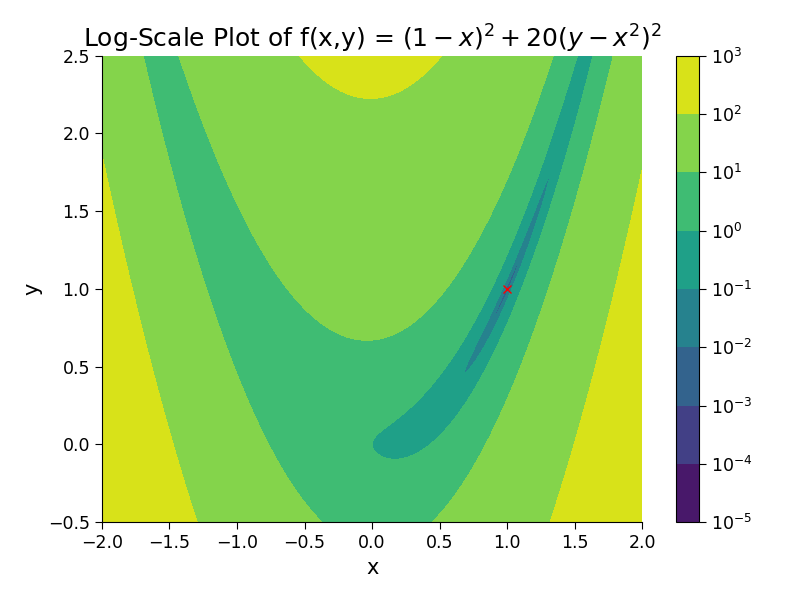

In [2]:
# @markdown **Run this cell** to plot the function we are optimizing

from matplotlib.colors import LogNorm

# Define the function
def rosenbock(x, y, a=1, b=20):
    return (a - x)**2 + b * (y - x**2)**2

# Generate the grid of x and y values
x = np.linspace(-2, 2, 400)
y = np.linspace(-0.5, 2.5, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbock(X, Y)

Z_positive = np.clip(Z, a_min=1e-10, a_max=None) # for log scaling plot

fig, ax = plt.subplots(figsize=(8, 6))

c = ax.contourf(X, Y, Z_positive, cmap='viridis', norm=LogNorm())
#c = ax.imshow(Z_positive, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', aspect='auto', norm=LogNorm())
ax.plot(1, 1, 'rx')  # Using 'rx' to mark the point (1,1) with a red "x"

# Add a color bar to interpret the colors
fig.colorbar(c, ax=ax)

ax.set_title('Log-Scale Plot of f(x,y) = $(1-x)^2 + 20 (y-x^2)^2$')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In this countour plot dark blue indicates lower values, and brighter green/yellow colors indicate higher values. Looking at the plot confirms that our analytic approach did indeed find a minimum at $(x,y) = (4,4)$. Now that we've seen how the analytic approach extends to 2-dimensions let's take a look at how our perturbation methods, propose and reject and perturb-measure-step work in 2-dimensions.

# 2.1.2.2: Optimizing a Two Dimensional Function with Propose and Reject

Below, is an interactive implementation of the propose-and-reject method applied to finding the maximum of our 2-d polynomial. Start by clicking 'Propose' to sample a new proposed $x,y$ value. Then, decide whether to 'Accept' or 'Reject' the proposed point based on a comparison with the previous point. Your goal is to find the lowest point in of this curve. 'Show History' is turned on to start so you can see all of the previous steps in the process. Similarly the 'Show Rejected' button is turned on so you can see all the tested points that have been rejected since the last accept.

In [3]:
# @title Stepping Through Optimization with Propose and Reject
# @markdown **Run this cell** to try your hand at manually finding the minimum of a Rosenbrock function using propose and reject.
class InteractivePolynomialProposeReject:
  def __init__(self,
               a = 1,
               b = 20,
               x_bounds=(-2, 2),
               y_bounds=(-0.5, 1.5),
               step_size=0.1, seed=None):
    self.a = a
    self.b = b
    self.x_bounds = x_bounds
    self.y_bounds = y_bounds
    self.step_size = step_size
    self.rng = np.random.default_rng(seed)
    self.current_x = -1.5
    self.current_y = 1.0
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.rejected_x = []
    self.rejected_y = []
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    self.fig, self.ax = plt.subplots(figsize=(6, 4))
    self.propose = widgets.Button(description='Propose')
    self.accept = widgets.Button(description='Accept', disabled=True)
    self.reject = widgets.Button(description='Reject', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    self.show_rejected = widgets.Checkbox(value=True, description='Show Rejected')
    self.in_loop = False
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    # Arrange widgets in a layout
    buttons_layout = widgets.VBox([
        widgets.HBox([self.propose, self.accept, self.reject]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history, self.show_rejected])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])
    #bind actions to handlers
    self.propose.on_click(self.on_propose_clicked)
    self.accept.on_click(self.on_accept_clicked)
    self.reject.on_click(self.on_reject_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_rejected.observe(self.on_show_rejected_toggled, 'value')
    self.show_history.observe(self.on_show_history_toggled, 'value')

  def init_plot(self):
    """Initialize the plot with placeholder data."""
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    # Initial plot commands return line objects, keep references to them
    self.contours = self.ax.contour(X, Y, Z, cmap='viridis', norm=LogNorm())
    self.point_current, = self.ax.plot([self.current_x], [self.current_y], 'bo', label='Current')
    self.point_proposed, = self.ax.plot([], [], 'go', label='Proposed')  # Empty data to start
    self.points_history, = self.ax.plot([], [], 'ks', alpha=0.5, label='History')  # Empty data to start
    self.points_rejected, = self.ax.plot([], [], 'kx', label='Rejected')  # Empty data to start
    self.ax.legend()
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def eval_function (self, x, y, a=None, b=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    return (a - x)**2 + b * (y - x**2)**2

  def on_propose_clicked(self, button):
    self.total_proposals += 1
    self.current_proposals += 1
    self.averaverage_proposals = self.acceptance_count / self.total_proposals
    perturbation_x, perturbation_y = self.rng.standard_normal(size=2) * self.step_size
    self.proposed_x = self.current_x + perturbation_x
    self.proposed_y = self.current_y + perturbation_y
    self.proposed_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    with self.narration_display:
      clear_output()
      print(f'Proposed x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Current x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z}')
      print("Click 'Accept' or 'Reject' to accept or reject this proposed x,y?")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = False
      self.reject.disabled = False
      self.propose.disabled = True
      self.full_step.disabled = True

  def on_accept_clicked(self, button):
    self.acceptance_count += 1
    self.current_proposals = 0
    with self.narration_display:
      clear_output()
      print(f'Accepted x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
      print(f'Average proposals per step: {self.total_proposals / self.acceptance_count:.3f}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = self.proposed_z
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.rejected_x = []
    self.rejected_y = []
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data([], [])
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_reject_clicked(self, button):
    self.rejected_x.append(self.proposed_x)
    self.rejected_y.append(self.proposed_y)
    with self.narration_display:
      clear_output()
      print(f'Rejected x: {self.proposed_x:.3f}, y: {self.proposed_y:.3f}, z: {self.proposed_z:.3f}.')
      print(f' Keeping x: {self.current_x:.3f}, y: {self.current_y:.3f}, z: {self.current_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Proposals evaluated since last step: {self.current_proposals}')
      print(f'Total number of proposals evaluated: {self.total_proposals}')
    self.proposed_x = None
    self.proposed_y = None
    self.point_proposed.set_data([], [])
    self.points_rejected.set_data(self.rejected_x, self.rejected_y)
    if not self.in_loop:
      self.fig.canvas.draw()
      self.accept.disabled = True
      self.reject.disabled = True
      self.propose.disabled = False
      self.full_step.disabled = False
      self.take_10_steps.disabled = False

  def on_full_step_clicked(self, button):
    # Automatically propose, accept if better, or reject
    self.full_step.disabled = True
    self.on_propose_clicked(button)
    if self.proposed_z < self.current_z:
        self.on_accept_clicked(button)
    else:
        self.on_reject_clicked(button)
    if not self.in_loop:
      self.full_step.disabled = False

  def on_take_10_steps_clicked(self, button):
    self.take_10_steps.disabled = True
    self.propose.disabled = True
    self.accept.disabled = True
    self.reject.disabled = True
    self.full_step.disabled = True
    self.in_loop = True
    for _ in range(10):
      self.on_full_step_clicked(button)
      self.fig.canvas.draw()
      time.sleep(0.6)
    self.in_loop = False
    self.take_10_steps.disabled = False
    self.propose.disabled = False
    self.full_step.disabled = False

  def on_reset_clicked(self, button):
    self.total_proposals = 0
    self.acceptance_count = 0
    self.current_proposals = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Generating a new curve for you to find the max of.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.y_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.proposed_x = None
    self.proposed_y = None
    self.proposed_z = None
    self.x_history = []
    self.y_history = []
    self.z_history = []
    self.accept.disabled = True
    self.reject.disabled = True
    self.propose.disabled = False
    self.point_current.set_data([self.current_x], [self.current_y])
    self.points_history.set_data(self.x_history, self.y_history)
    self.point_proposed.set_data([], [])
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_rejected_toggled(self, change):
    alpha = 0.5 if self.show_rejected.value else 0
    self.points_rejected.set_alpha(alpha)
    self.fig.canvas.draw_idle()


ippr = InteractivePolynomialProposeReject()
display(ippr.fig.canvas)
clear_output()
display(ippr.ui)

Depending on the shape of the function, and the initial starting point, this can work pretty well, but as in the one dimensional case there may potentially be a lot of proposals that lead to no improvement. For this particular function, which is relatively simple, propose and reject will end up accepting roughly half of the proposals, however for more exotically shaped functions this acceptance rate can be much lower. For example, if the current point is in a narrow valley, with only a very gentle downward slope, but very steep sides, then there are relatively few directions that will lead to lower values, really only steps that are oriented with this valley. Thus, once the process is in such a location we expect there to be relatively many proposals for every step taken. And, as in the one dimensional case, because we simply either accept or reject, these rejected proposal points do nothing further to guide our search for the minimizing $x$ and $y$ values, so in a sense each rejected proposal is wasted computation. In the one dimensional case we used a pertrub-measure-step approach to overcome the computational waste of rejected proposals, so that on each function evaluation we were able to make progress towards better parameter values. Now let's see what the perturb measure step approach looks like in two dimensions.

# 2.1.2.3 Optimizing a Two Dimensional Function with Perturb-Measure-Step

In [4]:
# @title Optimization with Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the minimum of 2 dimensional function using a perturb-measure-step approach.
class InteractivePolynomialSlopeStepper:
  def __init__(self,
               a=1.0, b=20.0,
               x_bounds=(0.6, 1.2),
               y_bounds=(0.6, 1.2),
               x_test_step_size=0.05,
               x_step_size=0.025,
               y_test_step_size=0.05,
               y_step_size=0.025,
               adjustable_step_size=False,
               seed=None):
    #constants
    self.a, self.b = a, b
    self.x_bounds, self.y_bounds = x_bounds, y_bounds
    #state
    self.current_x = 1.1
    self.current_y = 0.7
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.test_x, self.test_y, self.test_z = None, None, None
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_history, self.y_history, self.z_history = [], [], []
    self.total_function_evaluations = 0
    self.num_steps = 0
    #buttons
    self.x_test_step_slider = widgets.FloatSlider(
        value=x_test_step_size, min=-0.5, max=0.5, step=0.01,
        description='Test Step:', readout=True, readout_format='.2f')
    self.x_step_slider = widgets.FloatSlider(
        value=x_step_size, min=0.01, max=1.5, step=0.01,
        description='x Step:', readout=True, readout_format='.2f')
    self.y_test_step_slider = widgets.FloatSlider(
        value=y_test_step_size, min=-0.5, max=0.5, step=0.01,
        description='Test Step:', readout=True, readout_format='.2f')
    self.y_step_slider = widgets.FloatSlider(
        value=y_step_size, min=0.01, max=1.5, step=0.01,
        description='y Step:', readout=True, readout_format='.2f')
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.perturb_x = widgets.Button(description='Perturb x')
    self.measure_x = widgets.Button(description='Measure x', disabled=True)
    self.step_x = widgets.Button(description='Step x', disabled=True)
    self.perturb_y = widgets.Button(description='Perturb y')
    self.measure_y = widgets.Button(description='Measure y', disabled=True)
    self.step_y = widgets.Button(description='Step y', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    #bind buttons to action to handlers
    self.perturb_x.on_click(self.on_perturb_clicked)
    self.measure_x.on_click(self.on_measure_clicked)
    self.step_x.on_click(self.on_step_clicked)
    self.perturb_y.on_click(self.on_perturb_clicked)
    self.measure_y.on_click(self.on_measure_clicked)
    self.step_y.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_history.observe(self.on_show_history_toggled, 'value')
    self.x_step_slider.observe(self.on_step_slider_changed, 'value')
    self.x_test_step_slider.observe(self.on_test_step_slider_changed, 'value')
    self.y_step_slider.observe(self.on_step_slider_changed, 'value')
    self.y_test_step_slider.observe(self.on_test_step_slider_changed, 'value')
    #ui setup
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.x_test_step_slider, self.x_step_slider]),
        widgets.HBox([self.y_test_step_slider, self.y_step_slider]),
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb_x, self.measure_x, self.step_x]),
        widgets.HBox([self.perturb_y, self.measure_y, self.step_y]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

  def eval_function(self, x, y, a=None, b=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    return (a-x) ** 2 + (y-x**2) ** 2

  def init_plot(self):
    self.fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    self.ax_c = axs[1, 0]  # Contour plot axis
    self.ax_x = axs[0, 0]  # z(x), shares contour x-axis
    self.ax_y = axs[1, 1]  # z(y), shares contour y-axis
    self.ax_legend = axs[0, 1]  # Reserved for the legend
    self.ax_x.sharex(self.ax_c)
    self.ax_y.sharey(self.ax_c)
    # Contour Plot
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    self.contours = self.ax_c.contour(X, Y, Z, cmap='viridis', levels=50,
                                      norm=LogNorm())
    self.point_current, = self.ax_c.plot([self.current_x],
        [self.current_y], 'bo', label='Current')
    self.vline_current, = self.ax_c.plot([self.current_x, self.current_x],
                                         self.y_bounds, 'k--', alpha=0.3)
    self.hline_current, = self.ax_c.plot(self.x_bounds, [self.current_y, self.current_y],
                                         'k--', alpha=0.3)
    self.point_proposed, = self.ax_c.plot([], [], 'go',
                                          label='Proposed')
    self.points_history, = self.ax_c.plot([], [], 'ks', alpha=0.5,
                                        label='History', markersize=4)
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)

    #self.ax_x.set_xlabel('x')
    self.ax_x.set_ylabel('z')
    self.ax_c.set_ylabel('y')
    self.ax_c.set_xlabel('x')
    #self.ax_y.set_ylabel('y')
    self.ax_y.set_xlabel('z')

    # Adjust visibility of shared axis tick labels
    plt.setp(self.ax_x.get_xticklabels(), visible=False)
    plt.setp(self.ax_y.get_yticklabels(), visible=False)

    # Initial empty plots for marginal plots; they will be updated dynamically
    self.curve_z_of_x, = self.ax_x.plot([], [], 'r-', label='z(x) with y fixed')
    self.curve_z_of_y, = self.ax_y.plot([], [], 'b-', label='z(y) with x fixed')
    self.x_slope_line, = self.ax_x.plot([], [], 'g-')
    self.y_slope_line, = self.ax_y.plot([], [], 'g-')
    self.x_proposed_line, = self.ax_x.plot([], [], 'g--', alpha=0.5)
    self.y_proposed_line, = self.ax_y.plot([], [], 'g--', alpha=0.5)
    self.current_xz, = self.ax_x.plot([], [], 'bo')
    self.current_yz, = self.ax_y.plot([], [], 'bo')
    self.test_x_point, = self.ax_x.plot([], [], 'rx')
    self.test_y_point, = self.ax_y.plot([], [], 'rx', label='Test')
    self.xz_proposed_point, = self.ax_x.plot([], [], 'go')
    self.yz_proposed_point, = self.ax_y.plot([], [], 'go')
    self.update_z_of_x()
    self.update_z_of_y()
    self.ax_legend.axis('off')
    handles, labels = [], []
    for ax in [self.ax_c, self.ax_x, self.ax_y]:
      for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
    self.ax_legend.legend(handles, labels, loc='center')
    plt.tight_layout()
    self.fig.canvas.draw_idle()

  def update_z_of_x(self, fixed_y=None):
    if fixed_y is None:
      fixed_y = self.current_y
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.eval_function(x_vals, np.full_like(x_vals, fixed_y))
    self.curve_z_of_x.set_data(x_vals, z_vals)
    self.current_xz.set_data([self.current_x], [self.current_z])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_x.set_ylim(min_z - padding, max_z)

  def update_z_of_y(self, fixed_x=None):
    if fixed_x is None:
      fixed_x = self.current_x
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.eval_function(np.full_like(y_vals, fixed_x), y_vals)
    self.curve_z_of_y.set_data(z_vals, y_vals)
    self.current_yz.set_data([self.current_z], [self.current_y])
    min_z, max_z = z_vals.min(), z_vals.max()
    padding = (max_z - min_z) * 0.04
    self.ax_y.set_xlim(min_z - padding, max_z)

  def update_measure_x(self):
    rise = self.test_z - self.current_z
    run = self.test_x - self.current_x
    self.x_slope = rise / run
    self.xz_intercept = self.current_z - self.x_slope * self.current_x
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.x_slope * x_vals + self.xz_intercept
    self.x_slope_line.set_data(x_vals, z_vals)
    self.proposed_x = self.current_x - self.x_step_slider.value * self.x_slope
    self.step_xz = self.xz_intercept + self.x_slope * self.proposed_x
    self.xz_proposed_point.set_data([self.proposed_x], [self.step_xz])
    z_min, z_max = self.ax_x.get_ylim()
    self.x_proposed_line.set_data([self.proposed_x, self.proposed_x], [z_min, z_max])
    if self.proposed_y is None:
      self.point_proposed.set_data([self.proposed_x], [self.current_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def update_measure_y(self):
    rise = self.test_z - self.current_z
    run = self.test_y - self.current_y
    self.y_slope = rise / run
    self.yz_intercept = self.current_z - self.y_slope * self.current_y
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.y_slope * y_vals + self.yz_intercept
    self.y_slope_line.set_data(z_vals, y_vals)
    self.proposed_y = self.current_y - self.y_step_slider.value * self.y_slope
    self.step_yz = self.yz_intercept + self.y_slope * self.proposed_y
    self.yz_proposed_point.set_data([self.step_yz], [self.proposed_y])
    z_min, z_max = self.ax_y.get_xlim()
    self.y_proposed_line.set_data([z_min, z_max], [self.proposed_y, self.proposed_y])
    if self.proposed_x is None:
      self.point_proposed.set_data([self.current_x], [self.proposed_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button, axis=None):
    # are we perturbing x or y use axis or infer from button description
    if axis is None:
      if button.description == 'Perturb x':
        axis = 'x'
      elif button.description == 'Perturb y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Perturb x' or 'Perturb y'")
    if axis == 'x':
      self.test_x = self.current_x + self.x_test_step_slider.value
      self.test_y = self.current_y
      axis_is = 'x'
    elif axis == 'y':
        self.test_y = self.current_y + self.y_test_step_slider.value
        self.test_x = self.current_x
        axis_is = 'y'
    else:
      raise ValueError("Invalid axis, expected 'x' or 'y'")
    # calculate test value
    self.test_z = self.eval_function(self.test_x, self.test_y)
    self.total_function_evaluations += 1
    if axis == 'x':
      self.test_x_point.set_data([self.test_x], [self.test_z])
      self.measure_x.disabled = False
      self.perturb_x.disabled = True
      self.perturb_y.disabled = True
    elif axis == 'y':
      self.test_y_point.set_data([self.test_z], [self.test_y])
      self.measure_y.disabled = False
      self.perturb_y.disabled = True
      self.perturb_x.disabled = True
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test point: x = {self.test_x:.3f}, y = {self.test_y:.3f}, z = {self.test_z:.3f}.')
      print(f"Click 'Measure' to propose a new {axis_is} value based on this test point.")

  def on_measure_clicked(self, button, axis=None):
    if axis is None:
      if button.description == 'Measure x':
        axis = 'x'
      elif button.description == 'Measure y':
        axis = 'y'
      else:
        raise ValueError("Invalid button description, expected 'Measure x' or 'Measure y'")
    if axis == 'x':
      self.update_measure_x()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of x slope, proposed x step from {self.current_x:.3f} to {self.proposed_x:.3f}')
        print("Click 'Step x', to make the step.")
      self.step_x.disabled = False
      self.measure_x.disabled = True
    else: # axis == 'y':
      self.update_measure_y()
      with self.narration_display:
        clear_output(wait=True)
        print(f'Based on measurement of y slope, proposed y step from {self.current_y:.3f} to {self.proposed_y:.3f}')
        print("Click 'Step y', to make the step.")
        self.step_y.disabled = False
        self.measure_y.disabled = True

  def on_step_clicked(self, button):
    self.num_steps += 1
    if self.proposed_x is None and self.proposed_y is None:
      raise ValueError("At least one of proposed x and y values must be set before stepping.")
    if self.proposed_x is None:
      self.proposed_x = self.current_x
    if self.proposed_y is None:
      self.proposed_y = self.current_y
    new_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.total_function_evaluations += 1
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x = {self.proposed_x:.3f}, y = {self.proposed_y:.3f}, z = {new_z:.3f}.')
      print(f"Click 'Propose' or 'Do It For Me' to try a new value.")
      print(f'Total function evaluations so far: {self.total_function_evaluations}')
      print(f'Total number of steps taken so far: {self.num_steps}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = new_z
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()
    self.step_x.disabled = True
    self.step_y.disabled = True
    self.perturb_x.disabled = False
    self.perturb_y.disabled = False
    self.full_step.disabled = False
    self.take_10_steps.disabled = False

  def on_step_slider_changed(self, change):
    self.step_x = self.current_x + self.x_step_slider.value * self.slope
    self.step_y = self.slope * self.step_x + self.y_intercept
    self.step_point.set_data([self.step_x], [self.step_y])
    y_min, y_max = self.ax.get_ylim()
    self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_test_step_slider_changed(self, change):
    if self.test_step_slider.value == 0:
      # Set to a default non-zero value
      self.test_step_slider.value = 0.01
      with self.narration_display:
        print(f"Test step size of 0 cannot be used to calculate slope. Using 0.01 to avoid division by zero in slope calculation.")
    self.test_x = self.current_x + self.test_step_slider.value
    self.test_y = self.polynomial(self.test_x)
    self.test_point.set_data([self.test_x], [self.test_y])
    if self.step_x is not None:
      rise = self.test_y - self.current_y
      run = self.test_x - self.current_x
      self.slope = rise / run
      self.y_intercept = self.current_y - self.slope * self.current_x
      x_vals = np.linspace(self.bounds[0], self.bounds[1], 400)
      y_vals = self.slope * x_vals + self.y_intercept
      self.step_line.set_data(x_vals, y_vals)
      self.step_x = self.current_x + self.x_step_slider.value * self.slope
      self.step_y = self.slope * self.step_x + self.y_intercept
      self.step_point.set_data([self.step_x], [self.step_y])
      y_min, y_max = self.ax.get_ylim()
      self.step_vline.set_data([self.step_x, self.step_x], [y_min, self.step_y])
    self.fig.canvas.draw_idle()

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button, axis='x')
    self.on_measure_clicked(button, axis='x')
    self.on_step_clicked(button)
    self.on_perturb_clicked(button, axis='y')
    self.on_measure_clicked(button, axis='y')
    self.on_step_clicked(button)

  def on_take_10_steps_clicked(self, button):
    for _ in range(10):
      self.on_full_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Randomizing initial x and y values.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.x_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.x_history, self.y_history, self.z_history = [], [], []
    self.points_history.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ipss = InteractivePolynomialSlopeStepper()
display(ipss.fig.canvas)
clear_output()
display(ipss.ui)

So for this particular function, this perturb-measure-step approach is a bit more effective, starting at the same spot and using similar step sizes, we are able to zero in on the minimum of the curve with fewer function evaluations. With these methods and intutions in hand we're now ready to revisit our simple strike-no-strike problem where a lurk and strike predator must choose between striking and not strkining based on the activation level of a single sensory neuron.

works much better than propose and reject at first, but then slows down terribly once the current point starts to be in a very narrow valley, with steep sides, the floor of which slopes downward gently in a North-Easterly (increasing $x$ and $y$) direction. The issue is that if we only step in the $x$ direction (East or West) we run into the wall of the valley and so only take a very small step. Similarly if we only step in the $y$ direction (North or South) we run into the wall of the valley and so again we would only take a very small step. We can continue to make progress, but it requires taking very small step sizes, which makes progress towards the minimum very slow.

Now, there is a way to combine one of the advantage or propose and reject (testing both $x$ and $y$ dimensions simultaneously) with the advantages of perturb-measure-step (always making progress and not wasting comuptation). To do this we will perturb both $x$ and $y$ simultaneously, and then estimate the slope in both the $x$ and $y$ using a single evaluation of the test point.

In [5]:
# @title Optimization with simultaneous Perturb-Measure-Step
# @markdown **Run this cell** to step through finding the minimum of 2 dimensional function using a perturb-measure-step approach.
class InteractiveSimulPerturbMeasureStep:
  def __init__(self,
               a=1.0, b=20.0,
               x_bounds=(-2, 2),
               y_bounds=(-1, 3),
               test_step_size=0.25,
               x_step_size=0.05,
               y_step_size=0.05,
               adjustable_step_size=False,
               seed=None):
    #constants
    self.a, self.b = a, b
    self.x_bounds, self.y_bounds = x_bounds, y_bounds
    self.test_step_size = test_step_size
    self.x_step_size = x_step_size
    self.y_step_size = y_step_size
    #state
    self.current_x = -0.75
    self.current_y = 0.0
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.delta_x = self.test_step_size / np.sqrt(2)
    self.delta_y = self.test_step_size / np.sqrt(2)
    self.test_x = self.current_x + self.delta_x
    self.test_y = self.current_y + self.delta_y
    self.test_z = self.eval_function(self.test_x, self.test_y)
    self.delta_z = self.test_z - self.current_z
    self.total_function_evaluations = 2
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_history, self.y_history, self.z_history = [], [], []
    self.num_steps = 0
    #buttons
    self.adjustable_step_size = adjustable_step_size
    self.rng = np.random.default_rng(seed)
    self.perturb = widgets.Button(description='Perturb')
    self.measure = widgets.Button(description='Measure', disabled=True)
    self.step = widgets.Button(description='Step', disabled=True)
    self.full_step = widgets.Button(description='Do It For Me', disabled=True)
    self.take_10_steps = widgets.Button(description='Do 10 For Me', disabled=True)
    self.reset = widgets.Button(description='Reset')
    self.show_history = widgets.Checkbox(value=True, description='Show History')
    #bind buttons to action to handlers
    self.perturb.on_click(self.on_perturb_clicked)
    self.measure.on_click(self.on_measure_clicked)
    self.step.on_click(self.on_step_clicked)
    self.full_step.on_click(self.on_full_step_clicked)
    self.take_10_steps.on_click(self.on_take_10_steps_clicked)
    self.reset.on_click(self.on_reset_clicked)
    self.show_history.observe(self.on_show_history_toggled, 'value')
    #ui setup
    self.init_plot()
    self.narration_display = widgets.Output()
    remove_ip_clutter(self.fig)
    if self.adjustable_step_size:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.x_test_step_slider, self.x_step_slider]),
        widgets.HBox([self.y_test_step_slider, self.y_step_slider]),
        widgets.HBox([self.reset, self.show_history])])
    else:
      buttons_layout = widgets.VBox([
        widgets.HBox([self.perturb, self.measure, self.step]),
        widgets.HBox([self.full_step, self.take_10_steps]),
        widgets.HBox([self.reset, self.show_history])])
    buttons_and_narration = widgets.HBox([buttons_layout, self.narration_display])
    self.ui = widgets.VBox([self.fig.canvas, buttons_and_narration])

  def eval_function(self, x, y, a=None, b=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    return (a-x) ** 2 + (y-x**2) ** 2

  def eval_grad_function(self, x, y, a=None, b=None):
    if a is None:
      a = self.a
    if b is None:
      b = self.b
    return 2 * (a-x) - 2 * (y-x**2) * 2 * x, 2 * (y-x**2)

  def init_plot(self):
    self.fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    self.ax_c = axs[1, 0]  # Contour plot axis
    self.ax_x = axs[0, 0]  # z(x), shares contour x-axis
    self.ax_y = axs[1, 1]  # z(y), shares contour y-axis
    self.ax_xy = axs[0, 1] # Legend & z of test
    self.ax_x.sharex(self.ax_c)
    self.ax_y.sharey(self.ax_c)
    # Contour Plot
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = self.eval_function(X, Y)
    grad_x, grad_y = self.eval_grad_function(self.current_x, self.current_y)
    norm = np.sqrt(grad_x**2 + grad_y**2)
    grad_x, grad_y = grad_x / norm, grad_y / norm
    self.contours = self.ax_c.contour(X, Y, Z, cmap='viridis', levels=50,
                                      norm=LogNorm())
    self.point_current, = self.ax_c.plot([self.current_x],
        [self.current_y], 'bo')
    self.vline_current, = self.ax_c.plot([self.current_x, self.current_x],
                                         self.y_bounds, 'k--', alpha=0.3)
    self.hline_current, = self.ax_c.plot(self.x_bounds, [self.current_y, self.current_y],
                                         'k--', alpha=0.3)
    self.xy_test_line, = self.ax_c.plot([], [], 'k--', alpha=0.3)
    self.point_test, = self.ax_c.plot([], [], 'rx')
    self.test_radius_circle = plt.Circle((self.current_x, self.current_y), #center
                                         self.test_step_size, #radius
                                         color='red', fill=False, linestyle='--',
                                         linewidth=0.8, alpha=0.5)
    self.gradient_arrow = self.ax_c.annotate('', xy=(0, 0), xytext=(0, 0),
      arrowprops=dict(arrowstyle="->", color='r'))
    grad_x, grad_y = self.eval_grad_function(self.current_x, self.current_y)
    norm = np.sqrt(grad_x**2 + grad_y**2)
    grad_x, grad_y = grad_x / norm, grad_y / norm
    scale_factor = self.test_step_size
    end_x = self.current_x + (grad_x) * scale_factor
    end_y = self.current_y + (grad_y) * scale_factor
    self.gradient_arrow.set_position((self.current_x, self.current_y))
    self.gradient_arrow.xytext = (self.current_x, self.current_y)
    self.gradient_arrow.xy = (end_x, end_y)
    self.ax_c.add_patch(self.test_radius_circle)
    self.ax_c.add_artist(self.gradient_arrow)
    self.legend_arrow = self.ax_c.scatter(
        self.current_x, self.current_y, c='red', marker=r'$\rightarrow$',
        s=200, label='True Gradient', visible=True)
    self.point_proposed, = self.ax_c.plot([], [], 'go',)
    self.points_history, = self.ax_c.plot([], [], 'ks', alpha=0.5,
                                          label='History')
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    # set axis labels
    self.ax_x.set_ylabel('z')
    self.ax_c.set_ylabel('y')
    self.ax_c.set_xlabel('x')
    self.ax_y.set_xlabel('z')
    self.ax_xy.set_xlabel('$\Delta$xy-test')
    self.ax_xy.set_ylabel('z')
    # Adjust visibility of shared axis tick labels
    plt.setp(self.ax_y.get_yticklabels(), visible=False)
    plt.setp(self.ax_x.get_xticklabels(), visible=False)
    # Initial empty plots for marginal plots; they will be updated dynamically
    self.curve_z_of_x, = self.ax_x.plot([], [], 'r-', label='z(x) with y fixed')
    self.curve_z_of_y, = self.ax_y.plot([], [], 'b-', label='z(y) with x fixed')
    self.x_proposed_line, = self.ax_x.plot([], [], 'g--', alpha=0.5)
    self.y_proposed_line, = self.ax_y.plot([], [], 'g--', alpha=0.5)
    self.current_xz, = self.ax_x.plot([], [], 'bo')
    self.current_yz, = self.ax_y.plot([], [], 'bo')
    self.test_x_point, = self.ax_x.plot([], [], 'rx')
    self.test_y_point, = self.ax_y.plot([], [], 'rx')
    self.xz_proposed_point, = self.ax_x.plot([], [], 'go')
    self.yz_proposed_point, = self.ax_y.plot([], [], 'go')
    self.update_z_of_x()
    self.update_z_of_y()
    # Intial empty plots for z on xy-test
    self.curve_z_of_test, = self.ax_xy.plot([], [], 'k-', label='z along xy-test')
    self.xy_slope_line, = self.ax_xy.plot([], [], 'g-')
    self.xy_proposed_line, = self.ax_xy.plot([], [], 'g--', alpha=0.5)
    self.current_xy_z, = self.ax_xy.plot([], [], 'bo', label='Current')
    self.test_xy_z_point, = self.ax_xy.plot([], [], 'rx', label='Test')
    self.xy_z_proposed_point, = self.ax_xy.plot([], [], 'go', label='Proposed')
    self.update_z_of_test()
    # legends
    self.ax_c.legend(loc='upper left')
    self.ax_x.legend(loc='upper right')
    self.ax_y.legend(loc='lower right')
    self.ax_xy.legend(loc='upper right')
    self.legend_arrow.set_visible(False)
    # layout
    plt.tight_layout()
    self.fig.canvas.draw_idle()
    # set some initial points
    self.point_test.set_data([self.test_x], [self.test_y])
    self.test_x_point.set_data([self.test_x], [self.test_z])
    self.test_y_point.set_data([self.test_z], [self.test_y])
    print(f'Test point: x = {self.test_x:.3f}, y = {self.test_y:.3f}, z = {self.test_z:.3f}.')
    self.fig.canvas.draw()

  def update_z_of_x(self, fixed_y=None):
    if fixed_y is None:
      fixed_y = self.current_y
    x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 400)
    z_vals = self.eval_function(x_vals, np.full_like(x_vals, fixed_y))
    self.curve_z_of_x.set_data(x_vals, z_vals)
    self.current_xz.set_data([self.current_x], [self.current_z])
    min_z = min(z_vals.min(), self.test_z)
    max_z = max(z_vals.max(), self.test_z)
    padding = (max_z - min_z) * 0.04
    self.ax_x.set_ylim(min_z - padding, max_z)

  def update_z_of_y(self, fixed_x=None):
    if fixed_x is None:
      fixed_x = self.current_x
    y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 400)
    z_vals = self.eval_function(np.full_like(y_vals, fixed_x), y_vals)
    self.curve_z_of_y.set_data(z_vals, y_vals)
    self.current_yz.set_data([self.current_z], [self.current_y])
    min_z = min(z_vals.min(), self.test_z)
    max_z = max(z_vals.max(), self.test_z)
    padding = (max_z - min_z) * 0.04
    self.ax_y.set_xlim(min_z - padding, max_z)

  def update_z_of_test(self):
    m = self.delta_y / self.delta_x
    b = self.test_y - m * self.test_x
    x_at_y_min = (self.y_bounds[0] - b) / m
    x_at_y_max = (self.y_bounds[1] - b) / m
    y_at_x_min = m * self.x_bounds[0] + b
    y_at_x_max = m * self.x_bounds[1] + b
    intersections = []
    if self.x_bounds[0] <= x_at_y_min <= self.x_bounds[1]:
      intersections.append((x_at_y_min, self.y_bounds[0]))
    if self.x_bounds[0] <= x_at_y_max <= self.x_bounds[1]:
      intersections.append((x_at_y_max, self.y_bounds[1]))
    if self.y_bounds[0] <= y_at_x_min <= self.y_bounds[1]:
      intersections.append((self.x_bounds[0], y_at_x_min))
    if self.y_bounds[0] <= y_at_x_max <= self.y_bounds[1]:
      intersections.append((self.x_bounds[1], y_at_x_max))
    if len(intersections) != 2:
      raise ValueError("Test Point Likely Bad, didn't get the right number of intersections of the test line with the bounding box")
    # Now, sort the intersections based on x values
    intersections.sort()
    x_min, x_max = [point[0] for point in intersections]
    x_vals = np.linspace(x_min, x_max, 400)
    y_vals = b + m * x_vals
    self.xy_test_line.set_data(x_vals, y_vals)
    # Calculate signed distances for each point on the line from current_x, current_y
    base_delta_xy_normalized = np.array([self.delta_x, self.delta_y]) / np.sqrt(self.delta_x**2 + self.delta_y**2)
    delta_xy_vals = [np.array([x_ - self.current_x, y_ - self.current_y])
                     for x_, y_ in zip(x_vals, y_vals)]
    self.signed_deltas = [np.dot(delta_xy, base_delta_xy_normalized) for delta_xy in delta_xy_vals]
    # Calculate z values along the line
    z_vals = self.eval_function(x_vals, y_vals)
    self.curve_z_of_test.set_data(self.signed_deltas, z_vals)
    # Set data for the current position marker
    self.current_xy_z.set_data([0], [self.current_z])
    # Calculate the signed distance from current to test point for the test point marker
    self.test_delta_xy = np.array([self.test_x - self.current_x, self.test_y - self.current_y])
    self.test_signed_distance = np.dot(self.test_delta_xy, base_delta_xy_normalized)
    self.test_xy_z_point.set_data([self.test_signed_distance], [self.test_z])
    # Adjust plot limits
    min_z, max_z = z_vals.min(), z_vals.max()
    min_dist, max_dist = min(self.signed_deltas), max(self.signed_deltas)
    padding_z = (max_z - min_z) * 0.04
    self.ax_xy.set_ylim(min_z - padding_z, max_z + padding_z)
    self.ax_xy.set_xlim(min_dist, max_dist)

  def update_measure(self):
    rise = self.delta_z
    run = self.test_signed_distance
    self.slope = rise / run
    self.xy_z_intercept = self.current_z
    z_vals = self.slope * self.test_signed_distance
    self.xy_slope_line.set_data(self.test_signed_distance, z_vals)
    self.proposed_x = self.current_x - self.param_step_size * self.x_slope
    self.step_xz = self.xz_intercept + self.x_slope * self.proposed_x
    self.xz_proposed_point.set_data([self.proposed_x], [self.step_xz])
    z_min, z_max = self.ax_x.get_ylim()
    self.x_proposed_line.set_data([self.proposed_x, self.proposed_x], [self.step_xz, z_max])
    if self.proposed_y is None:
      self.point_proposed.set_data([self.proposed_x], [self.current_y])
    else:
      self.point_proposed.set_data([self.proposed_x], [self.proposed_y])
    self.fig.canvas.draw_idle()

  def on_perturb_clicked(self, button, axis=None):
    offsets = self.rng.normal(0, 1, 2)
    magnitude = np.sqrt(np.sum(offsets**2))
    self.delta_x = (offsets[0] / magnitude) * self.test_step_size
    self.delta_y = (offsets[1] / magnitude) * self.test_step_size
    # Calculate the new test point
    self.test_x = self.current_x + self.delta_x
    self.test_y = self.current_y + self.delta_y
    self.test_z = self.eval_function(self.test_x, self.test_y)
    self.delta_z = self.test_z - self.current_z
    self.total_function_evaluations += 1
    self.point_test.set_data([self.test_x], [self.test_y])
    self.test_x_point.set_data([self.test_x], [self.test_z])
    self.test_y_point.set_data([self.test_z], [self.test_y])
    self.update_z_of_test()
    self.measure.disabled = False
    self.perturb.disabled = True
    self.perturb.disabled = True
    self.fig.canvas.draw_idle()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Test point: x = {self.test_x:.3f}, y = {self.test_y:.3f}, z = {self.test_z:.3f}.')
      print(f"Click 'Measure' to propose a new x and y values based on this test point.")

  def on_measure_clicked(self, button, axis=None):
    self.update_measure()
    with self.narration_display:
      clear_output(wait=True)
      print(f'Based on measurement of x proposed x step from {self.current_x:.3f} to {self.proposed_x:.3f}')
      print(f'Based on measurement of y proposed y step from {self.current_y:.3f} to {self.proposed_y:.3f}')
      print("Click 'Step', to make the step.")
    self.step.disabled = False
    self.measure.disabled = True

  def on_step_clicked(self, button):
    self.num_steps += 1
    if self.proposed_x is None and self.proposed_y is None:
      raise ValueError("At least one of proposed x and y values must be set before stepping.")
    if self.proposed_x is None:
      self.proposed_x = self.current_x
    if self.proposed_y is None:
      self.proposed_y = self.current_y
    new_z = self.eval_function(self.proposed_x, self.proposed_y)
    self.total_function_evaluations += 1
    with self.narration_display:
      clear_output(wait=True)
      print(f'Stepped to x = {self.proposed_x:.3f}, y = {self.proposed_y:.3f}, z = {new_z:.3f}.')
      print(f"Click 'Peturb' or 'Do It For Me' to try a new value.")
      print(f'Total function evaluations so far: {self.total_function_evaluations}')
      print(f'Total number of steps taken so far: {self.num_steps}')
    self.x_history.append(self.current_x)
    self.y_history.append(self.current_y)
    self.z_history.append(self.current_z)
    self.points_history.set_data(self.x_history, self.y_history)
    self.current_x = self.proposed_x
    self.current_y = self.proposed_y
    self.current_z = new_z
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_radius_circle.center = (self.current_x, self.current_y)
    grad_x, grad_y = self.eval_grad_function(self.current_x, self.current_y)
    norm = np.sqrt(grad_x**2 + grad_y**2)
    grad_x, grad_y = grad_x / norm, grad_y / norm
    scale_factor = self.test_step_slider.value
    end_x = self.current_x + (grad_x) * scale_factor
    end_y = self.current_y + (grad_y) * scale_factor
    self.gradient_arrow.set_position((self.current_x, self.current_y))
    self.gradient_arrow.xytext = (self.current_x, self.current_y)
    self.gradient_arrow.xy = (end_x, end_y)
    self.test_x, self.test_y, self.test_z = None, None, None
    self.point_test.set_data([], [])
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()
    self.step.disabled = True
    self.perturb.disabled = False
    self.full_step.disabled = False
    self.take_10_steps.disabled = False

  def on_full_step_clicked(self, button):
    self.on_perturb_clicked(button)
    self.on_measure_clicked(button)
    self.on_step_clicked(button)

  def on_take_10_steps_clicked(self, button):
    for _ in range(10):
      self.on_full_step_clicked(button)

  def on_reset_clicked(self, button):
    self.proposals_evaluated = 0
    with self.narration_display:
      clear_output(wait=True)
      print(f'Reset. Clearing history')
      print(f'Randomizing initial x and y values.')
    self.current_x = self.rng.uniform(self.x_bounds[0], self.x_bounds[1])
    self.current_y = self.rng.uniform(self.y_bounds[0], self.y_bounds[1])
    self.current_z = self.eval_function(self.current_x, self.current_y)
    self.point_current.set_data([self.current_x], [self.current_y])
    self.vline_current.set_data([self.current_x, self.current_x], self.y_bounds)
    self.hline_current.set_data(self.x_bounds, [self.current_y, self.current_y])
    self.test_x, self.test_y, self.test_z = None, None, None
    self.test_x_point.set_data([], [])
    self.test_y_point.set_data([], [])
    self.proposed_x, self.proposed_y, self.proposed_z = None, None, None
    self.x_proposed_line.set_data([], [])
    self.y_proposed_line.set_data([], [])
    self.yz_proposed_point.set_data([], [])
    self.xz_proposed_point.set_data([], [])
    self.point_proposed.set_data([], [])
    self.x_slope_line.set_data([], [])
    self.y_slope_line.set_data([], [])
    self.x_history, self.y_history, self.z_history = [], [], []
    self.points_history.set_data([], [])
    self.update_z_of_x()
    self.update_z_of_y()
    self.fig.canvas.draw_idle()

  def on_show_curve_toggled(self, change):
    alpha = 1 if self.show_curve.value else 0
    self.line_polynomial.set_alpha(alpha)
    self.fig.canvas.draw_idle()

  def on_show_history_toggled(self, change):
    alpha = 0.5 if self.show_history.value else 0
    self.points_history.set_alpha(alpha)
    self.fig.canvas.draw_idle()



ispms = InteractiveSimulPerturbMeasureStep()
display(ispms.fig.canvas)
clear_output()
display(ispms.ui)